## Fetching a NEXRAD file and extracting a column

<a href='https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long'> This Stack overflow post </a> Gives a way to get the range and azimuth between two lat lon points. 

For our example here we are going to use the ARM deployment to Houston as an example and extract a column over ARM site at La Porte from the KHGX NEXRAD volume.


In [124]:
import nexradaws
import tempfile
import os
import shutil
import pyart
import pytz
import pyproj
from datetime import datetime, timedelta
import act

import xarray as xr

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np

from geographiclib.geodesic import Geodesic



In [11]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = tlocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

In [52]:
conn = nexradaws.NexradAwsInterface()
recent_time = datetime(2021, 9, 29, 11, 30, 0).replace(tzinfo=pytz.UTC)

my_radar = get_my_radar(conn, 'KHGX', recent_time)

181 181
Downloaded KHGX20210929_112914_V06
1 out of 1 files downloaded...0 errors


Lets check the location of our radar!

In [53]:
print(my_radar.longitude)
print(my_radar.latitude)


{'long_name': 'Longitude', 'standard_name': 'Longitude', 'units': 'degrees_east', 'data': array([-95.07873535])}
{'long_name': 'Latitude', 'standard_name': 'Latitude', 'units': 'degrees_north', 'data': array([29.47190094])}


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

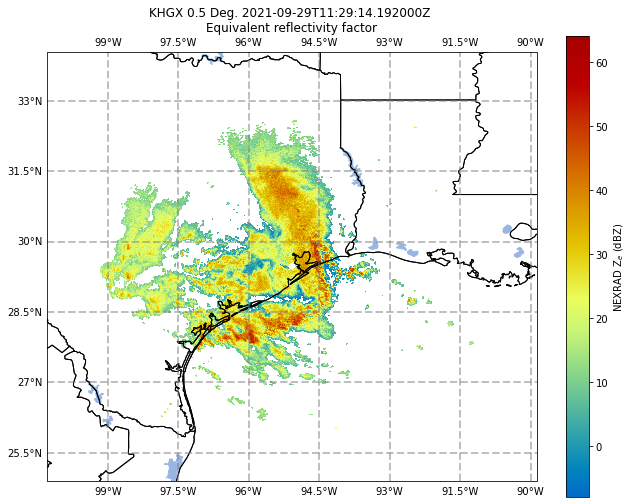

In [54]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(my_radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)

HOU M1: La Porte, Texas
HOU M1 Latitude:   29.67
HOU M1 Longitude: -95.059
HOU M1 Altitude:    8


In [62]:
site_lat = 29.67
site_lon = -95.059
radar_lat = my_radar.latitude['data'][0]
radar_lon = my_radar.longitude['data'][0]



/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

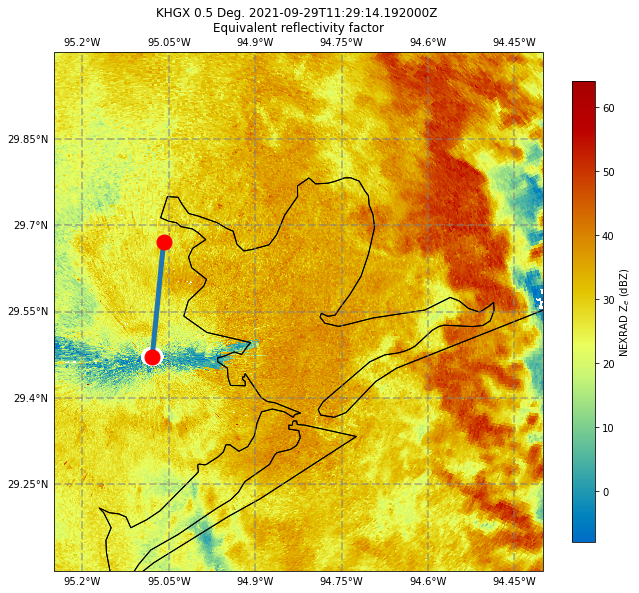

In [56]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(my_radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, 
                 colorbar_flag=False)

plt.xlim(-95.25,-94.4)
plt.ylim(29.1, 30.)

ax.plot([site_lon, radar_lon], [site_lat, radar_lat], linewidth=5.0)
ax.plot([site_lon, radar_lon], [site_lat, radar_lat], 'ro', markersize=15.0)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)

In [69]:
rng = Geodesic.WGS84.Inverse(radar_lat, radar_lon, site_lat , site_lon)['s12']
brg = Geodesic.WGS84.Inverse(radar_lat, radar_lon, site_lat , site_lon)['azi1']


In [70]:
print(rng, brg)

22041.4525369963 4.972403237818765


In [84]:
ray500_x = my_radar.gate_x['data'][9500,:]
ray500_y = my_radar.gate_y['data'][9500,:]
r = np.sqrt(ray500_x**2 + ray500_y**2)
dist = my_radar.range['data']

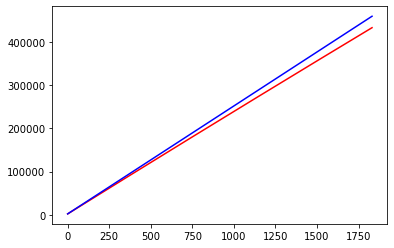

In [86]:
plt.plot(r, 'r-')
plt.plot(dist, 'b-')


In [82]:
my_radar.gate_x['data'].shape

(10080, 1832)

In [117]:
debug = False

#empty list for the values
vals = []

#Keys, or fields, in the radar file.. what values do we want to extract
rkeys = my_radar.fields.keys()

#Loop over all sweeps.. Assumes a PPI
for i in range(len(my_radar.sweep_end_ray_index['data'])):
    
    #grab a sweep
    sweep = my_radar.extract_sweeps([i])
    
    #work out the index of the nearest azimuth to the azimuth we are searching for
    az_num = list(sweep.azimuth['data']).index(nearest(sweep.azimuth['data'], brg))
    
    if debug:
        print(az_num, sweep.azimuth['data'][az_num])
    
    #work out the distance along the ground of the radar gates
    distance_along_ground = np.sqrt(sweep.gate_x['data']**2 + sweep.gate_y['data']**2 )[az_num, :]
    
    #Work out the index of the closest gate
    gate_num = list(distance_along_ground).index(nearest(distance_along_ground, rng))
    
    if debug:
        print(gate_num, distance_along_ground[gate_num])
    
    #This nasty bit of code makes a dictionary with the required gate value for that sweep
    gate_vals =  dict([(thiskey, sweep.fields[thiskey]['data'][az_num, gate_num]) for thiskey in rkeys])
    
    #Construct a dictionary of information about the radar gate
    loc_info = {'range': sweep.range['data'][gate_num],
               'lat' : sweep.gate_latitude['data'][az_num, gate_num],
               'lon' : sweep.gate_longitude['data'][az_num, gate_num],
               'height' : sweep.gate_altitude['data'][az_num, gate_num],
               'time' : sweep.time['data'][az_num],
               'time_units' : sweep.time['units']}
    vals.append({'loc_info' : loc_info, 'fields' : gate_vals})
    

In [118]:
vals[0]

{'loc_info': {'range': 22125.0,
  'lat': 29.670182118076184,
  'lon': -95.05978890625622,
  'height': 232.0,
  'time': 13.50800000000163,
  'time_units': 'seconds since 2021-09-29T11:29:14Z'},
 'fields': {'velocity': masked,
  'differential_reflectivity': 0.25,
  'spectrum_width': masked,
  'differential_phase': 66.28821,
  'cross_correlation_ratio': 0.9916667,
  'reflectivity': 28.5,
  'clutter_filter_power_removed': -6.0}}

In [136]:
column = {}
heights =  np.array([vals[i]['loc_info']['height'] for i in range(len(vals))])

indx = heights.argsort()
heights = heights[indx]

for kval in vals[0]['fields'].keys():
    column.update({kval: np.array([vals[i]['fields'][kval] for i in range(len(vals)) ])[indx]})



    

/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  


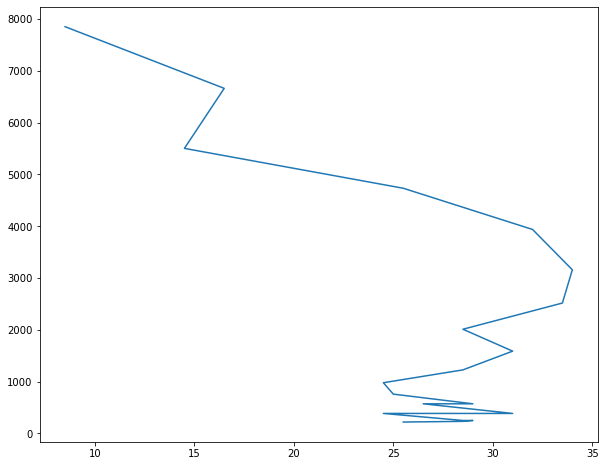

In [140]:
figme = plt.figure(figsize=[10,8])
plt.plot(column['reflectivity'], heights)